# Battle of The Brands: Capstone Final Project


# Introduction and Business Problem

**Introduction:**
- In Egypt, many outings revolve around having a delicious meal followed by spending some time in Cafe. With the large number of opening restaurants offering different cusine, it becomes rather hard to determine which restaurants are worth going to and how far they are.
    
    
    
**Business Problem:**
- This project aims to provide simple guide on where to eat based on Foursquare ratings, price, category and geographic location data for restaurants in Great Cairo.  The restaurants would be grouped (clustered) based on their similarities so that it can be easily determined what type cuisine they are looking for and in its price range.

# Data Required

For this task, Foursquare API will be used to retrieve data for restaurants in Great Cairo:
- Venue Name
- Venue ID
- Venue Location
- Venue Category
- Rating
- Price
- Likes
- Phrases

# Data Acquisition

To acquire the needed data the following shall be done:

- Retrieve list of districts in Great Cairo
- Use geolocator to obtain coordinates (latitude and longitude) for fetched districts
- Retrieve a list of all venues in these districts
- Retrieve venue IDs for each venue
- Retrieve venue name, location, category, etc.. for each venue

# Data Usage

The aforementioned gathered data shall be fed into a clustering algorithim (k-means clustering algorithm being the one of choice) and using methods, the appropriate number of K shall be determined and consequently used allowing people looking to hang out whether it's in a cafe or restaurant to see which restaurants will quench their thirst and satisfy their crave

   ### Importing necessery packages

In [1]:
# !conda install -c conda-forge folium

In [2]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from urllib.request import urlopen
from bs4 import BeautifulSoup
import json 
import re
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize as json_to_df
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import folium


In [3]:
%matplotlib inline

# Segmenting and Clustering Neighborhoods in Great Cairo

## 1. Data scraping

#### Description: 
The following Wikipedia page https://en.wikipedia.org/wiki/Template:Districts_of_Cairo/sandbox contains the names of the districts in (Great) Cairo which are needed and thus we need to crawl the url, retrieve the data, parse it and then transform it into a pandas dataframe.


In [4]:
# Define the dataframe columns
column_names = ['District', 'Latitude', 'Longitude'] 

# Create the dataframe
df_districts = pd.DataFrame(columns=column_names)
df_districts

,District,Latitude,Longitude


#### Web crawling/scraping
##### Importing data from provided URL

In [5]:
#Districts URL
wiki_url = "https://en.wikipedia.org/wiki/Template:Districts_of_Cairo/sandbox"

#Retrieve the wikipedia page
page = urlopen(wiki_url)

#Parse HTML
soup = BeautifulSoup(page, "lxml")

#Get table 
district_table = soup.find('table', class_='nowraplinks collapsible autocollapse navbox-inner')

#### Extract the district names from the table

In [6]:
districts = district_table.findAll("a")[5::]
districts = [re.sub(" \(.*\)", "", link.get('title')) for link in districts if link.get('title') is not None]

districts[4] = "Daher"
districts[33] = "5th Settlement"
districts.pop(16)
districts.pop(34)
districts.pop(23)
districts.append("1st Settlement")
districts.append("3rd Settlement")
districts.append("El Rehab")
districts.append("6th of October")
districts.append("El Sheikh Zayed")

#### Retrieve coordinates of the districts

In [7]:
latitude = []
longitude = []
for district in districts:
    address = district + ", Egypt"
    geolocator = Nominatim(user_agent="BoTB")
    location = geolocator.geocode(address, timeout=60, exactly_one=True)
    if location is not None:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
        # print("The coordinates of {} are {}, {}".format(address, location.latitude, location.longitude))
    else:
        latitude.append(None)
        longitude.append(None) 

#### Create dataframe containing districts' info

In [8]:
df_districts['District'] = districts
df_districts['Latitude'] = latitude
df_districts['Longitude'] = longitude

#Drop rows where the district coords are "NaN"
df_districts = df_districts.dropna()

#Reset Index
df_districts.index = pd.RangeIndex(len(df_districts.index))
df_districts

,District,Latitude,Longitude
0,Abbassia,31.146455,29.784960
1,Ain Shams,30.130476,31.316749
2,Azbakeya,30.053889,31.245473
3,Boulaq,30.063093,31.228926
4,Daher,30.046661,31.323637
5,El-Manial,30.027673,31.229000
6,El-Marg,30.152778,31.338333
7,Mokattam,30.033333,31.283333
8,Nasr City,30.052118,31.342205
9,Obour City,30.191400,31.450548


#### Using geopy library to get the latitude and longitude values of Cairo.

In [9]:
address = "Cairo, Egypt"
geolocator = Nominatim(user_agent="BoTB")
location = geolocator.geocode(address, timeout=60, exactly_one=True)
latitude = location.latitude
longitude = location.longitude
print("The coordinates of {} are {}, {}".format(address, location.latitude, location.longitude))

The coordinates of Cairo, Egypt are 30.048819, 31.243666


## Create a map of Great Cairo

In [10]:
# Create map of Great Cairo using latitude and longitude values
map_cairo = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add district markers to map
for lat, lng, district in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District']):
    label = '{}, Great Cairo'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cairo)  
    
map_cairo

## Utilizing the Foursquare API to explore the districts.
#### Foursquare Credentials and Version

In [11]:
# CLIENT_ID = 'MGXFGFJIL0WOWMIEFBY22MZACR4Y0CIGIKP552AK21A4IFJY' # Foursquare ID
# CLIENT_SECRET = 'TIASMHFUXM24RDBN1TMPSQOCIGSCVL12YGB2302VJRXBVBUG' # Foursquare Secret
CLIENT_ID = 'UI1GTXNA5FGGAMAHX13BSP0G1UZVUD5ZRRYMIGZXBLSMQVPG'
CLIENT_SECRET = 'NUGVEFSFR33GPNEDNYYAXBDL0KK2YD1XMFMPH3PLSP3R05RE'
VERSION = '20180605' # Foursquare API version

### Let's explore the first neighborhood in our dataframe.
Get the neighborhood's details


In [12]:
df_districts.loc[0]
district_latitude = np.float(df_districts.loc[0,['Latitude']].values)
district_longitude =  np.float(df_districts.loc[0,['Longitude']].values)

#### Now, let's get the top 25 venues that are in Cairo within a radius of 500 meters.
First, let's create the GET request URL. Naming the URL url.

In [13]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    500)

####  Extracting the  category of the venue

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Retrieve data using Foursquare API

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c8ff2d6db04f50dae79a071'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-53d928bd498ea9f619d7fa4f-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d103951735',
         'name': 'Clothing Store',
         'pluralName': 'Clothing Stores',
         'primary': True,
         'shortName': 'Apparel'}],
       'id': '53d928bd498ea9f619d7fa4f',
       'location': {'address': '165 Mohamed Farid St',
        'cc': 'EG',
        'city': 'وسط البلد',
        'country': 'مصر',
        'crossStreet': 'Abd El Khalek Tharwat St',
        'distance': 188,
        'formattedAddress': ['165 Mohamed Farid St (Abd El Khalek Tharwat St)',
         'وسط البلد',
         'القاهرة',

### Cleaning the json and structuring it into a pandas dataframe.

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_to_df(venues) # flatten JSON

# Filter columns
# filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# Clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng
0,Halawa (حلاوه),53d928bd498ea9f619d7fa4f,Clothing Store,30.050450,31.244201
1,Simonds,4d08b03643b36ea8d01e2eef,Coffee Shop,30.049971,31.242260
2,Costa Coffee,56e3232bcd1044008992e42c,Coffee Shop,30.048983,31.242256
3,Happy City Roof Bar,4dc06c62a86e2f4250c0e0a8,Hotel Bar,30.046346,31.243932
4,Dar El Maaref (دار المعارف),50bcf0fee4b01958503639d1,Bookstore,30.050467,31.242328


#### How many venues were returned by Foursquare?

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

30 venues were returned by Foursquare.


### Exploring all the districts

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius) #, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [19]:
def getVenueUrls(venue_id_list, url_list=[]):
    for v_id in venue_id_list:
        venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(v_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        url_list.append(venue_url)
    return url_list

In [20]:
def getVenueLikeCount(url_list, likes_list=[]):
    for link in url_list:
        result = requests.get(link).json()
        print(result)
        likes = result['response']['likes']['count']
        likes_list.append(likes)
    return likes_list

### Cairo Venues

In [21]:
cairo_venues = getNearbyVenues(names=df_districts['District'],
                                   latitudes=df_districts['Latitude'],
                                   longitudes=df_districts['Longitude']
                                  )

Abbassia
Ain Shams
Azbakeya
Boulaq
Daher
El-Manial
El-Marg
Mokattam
Nasr City
Obour City
El-Sakakini
Shobra
Rod El Farag
Shubra El-Kheima
Zeitoun, Cairo
Coptic Cairo
Downtown Cairo
Fustat
Islamic Cairo
Old Cairo
Garden City
Heliopolis
Maadi
5th Settlement
Zamalek
Agouza
Giza
Haram
Imbaba
Mohandessin
Dokki
1st Settlement
3rd Settlement
El Rehab
6th of October
El Sheikh Zayed


#### Size of dataframe

In [22]:
print(cairo_venues.shape)
cairo_venues.head()

(422, 8)


,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude
0,Ain Shams,30.130476,31.316749,El Wally Cafe,50d766bae4b023bf8cc4191c,Café,30.130768,31.317696
1,Ain Shams,30.130476,31.316749,محطة عين شمس,4ea04b0b30f854cd9c42c9b9,Metro Station,30.126968,31.318420
2,Ain Shams,30.130476,31.316749,43's Bus Station,4e0fc35f6365434360093889,Bus Station,30.126521,31.316418
3,Ain Shams,30.130476,31.316749,Mo'men (مؤمن),4f98614fe4b0fc88e6fea24d,Fast Food Restaurant,30.127758,31.320648
4,Azbakeya,30.053889,31.245473,Windsor Hotel Cairo,4bcf68e70ffdce72b771b2c0,Hotel,30.053602,31.245593


Let's check how many venues were returned for each district

In [23]:
cairo_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude
District,,,,,,,
1st Settlement,4,4,4,4,4,4,4
3rd Settlement,4,4,4,4,4,4,4
5th Settlement,4,4,4,4,4,4,4
6th of October,26,26,26,26,26,26,26
Agouza,10,10,10,10,10,10,10
Ain Shams,4,4,4,4,4,4,4
Azbakeya,30,30,30,30,30,30,30
Boulaq,18,18,18,18,18,18,18
Coptic Cairo,10,10,10,10,10,10,10


In [24]:
print('There are {} total uniques categories.'.format(len(cairo_venues['Venue Category'].unique())))

There are 132 total uniques categories.


### Remove any unrelated venues

In [25]:
cairo_venues_bak = cairo_venues.copy()

In [26]:
food_and_cafe = ['Café', 'Fast Food Restaurant', 'Bakery', 'Pastry Shop'
                  'Italian Restaurant', 'Egyptian Restaurant',
                  'Falafel Restaurant', 'Dessert Shop',
                  'Swiss Restaurant', 'Middle Eastern Restaurant', 'Coffee Shop',
                  'Restaurant', 'Asian Restaurant', 'Steakhouse',
                  'Thai Restaurant', 'Diner', 'Hookah Bar', 'Yemeni Restaurant', 'Juice Bar', 'Sandwich Place', 'Cafeteria',
                  'Hot Dog Joint', 'Pizza Place', 'Snack Place', 'Pie Shop',
                  'Seafood Restaurant', 'Syrian Restaurant', 'Shawarma Place', 
                  'Indian Restaurant', 'Kebab Restaurant',
                  'Lebanese Restaurant', 'Dim Sum Restaurant', 'Turkish Restaurant',
                  'French Restaurant', 'Tapas Restaurant', 'Food Truck',
                  'Cupcake Shop', 'Cuban Restaurant', 'Ice Cream Shop',
                  'Sushi Restaurant', 'German Restaurant', 'Candy Store','Burger Joint',
                  'Mexican Restaurant','Chinese Restaurant', 'Salad Place',
                  'Peruvian Restaurant', 'Pub', 'Food Stand', 'American Restaurant', 
                  'Japanese Restaurant', 'Korean Restaurant', 'Modern European Restaurant',
                  'Eastern European Restaurant', 'Donut Shop', 'Fried Chicken Joint']
cairo_venues = cairo_venues[cairo_venues['Venue Category'].isin(food_and_cafe)]
cairo_venues

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude
0,Ain Shams,30.130476,31.316749,El Wally Cafe,50d766bae4b023bf8cc4191c,Café,30.130768,31.317696
3,Ain Shams,30.130476,31.316749,Mo'men (مؤمن),4f98614fe4b0fc88e6fea24d,Fast Food Restaurant,30.127758,31.320648
6,Azbakeya,30.053889,31.245473,Latif Wassily (لطيف وسيلي),4f7e9104e4b0e160b786d8dd,Bakery,30.054508,31.248270
12,Azbakeya,30.053889,31.245473,Al Americaine (الأمريكين),4eb2c4a7cc21adeaf89acb9a,Café,30.052561,31.244304
19,Azbakeya,30.053889,31.245473,Shalaby Hawawshi (حواوشي شلبي),506486d8e4b0593606e72415,Egyptian Restaurant,30.053207,31.242935
20,Azbakeya,30.053889,31.245473,McDonald's,4db0b701fa8ca4b3e9e83b90,Fast Food Restaurant,30.051956,31.241425
22,Azbakeya,30.053889,31.245473,Koshary Sayed Hanafy (كشرى سيد حنفى),53400cf9498e9792e60acab6,Egyptian Restaurant,30.053527,31.242905
23,Azbakeya,30.053889,31.245473,El Tabei El Domyati (التابعى الدمياطى),4e856185cc2143d95495b059,Falafel Restaurant,30.056195,31.242615
25,Azbakeya,30.053889,31.245473,Akher Sa'a (أخر ساعة),5047b0bfe4b0ea030c588261,Falafel Restaurant,30.053594,31.243780
26,Azbakeya,30.053889,31.245473,La Poire Cafe,4fd9b0f2e4b06a851a06d49a,Dessert Shop,30.050434,31.242612


#### Let's find out how many unique categories can be curated from all the returned venues

In [27]:
print('There are {} related uniques categories.'.format(len(cairo_venues['Venue Category'].unique())))

There are 53 related uniques categories.


## District analysis

In [28]:
cairo_venues['Like Count'] = getVenueLikeCount(getVenueUrls(cairo_venues['Venue ID'].tolist()))

{'meta': {'code': 200, 'requestId': '5c8ff2dfdd57973aae8b857d'}, 'response': {'likes': {'count': 2, 'summary': '2 Likes', 'items': [{'id': '45551864', 'photo': {'suffix': '/45551864-SAB2ABHN1UAX3PUE.jpg', 'prefix': 'https://fastly.4sqi.net/img/user/'}, 'gender': 'male', 'lastName': 'Yousef', 'firstName': 'Ahmed'}, {'id': '55972919', 'photo': {'suffix': '/S0WSAJPP5GDKMRYN.jpg', 'prefix': 'https://fastly.4sqi.net/img/user/'}, 'gender': 'male', 'lastName': 'Magdy', 'firstName': 'Amr'}]}}}
{'meta': {'code': 200, 'requestId': '5c8ff2df9fb6b753693456d4'}, 'response': {'likes': {'count': 1, 'summary': '1 Like', 'items': [{'id': '56279542', 'photo': {'suffix': '/56279542-RBRMO3RWNLX21DQU.jpg', 'prefix': 'https://fastly.4sqi.net/img/user/'}, 'gender': 'male', 'lastName': 'Abass', 'firstName': 'bedo'}]}}}
{'meta': {'code': 200, 'requestId': '5c8ff2e01ed219672a1018d3'}, 'response': {'likes': {'count': 28, 'summary': '28 Likes', 'items': [{'id': '84829218', 'photo': {'suffix': '/84829218_CKAmEzz1_

In [29]:
cairo_venues

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count
0,Ain Shams,30.130476,31.316749,El Wally Cafe,50d766bae4b023bf8cc4191c,Café,30.130768,31.317696,2
3,Ain Shams,30.130476,31.316749,Mo'men (مؤمن),4f98614fe4b0fc88e6fea24d,Fast Food Restaurant,30.127758,31.320648,1
6,Azbakeya,30.053889,31.245473,Latif Wassily (لطيف وسيلي),4f7e9104e4b0e160b786d8dd,Bakery,30.054508,31.248270,28
12,Azbakeya,30.053889,31.245473,Al Americaine (الأمريكين),4eb2c4a7cc21adeaf89acb9a,Café,30.052561,31.244304,35
19,Azbakeya,30.053889,31.245473,Shalaby Hawawshi (حواوشي شلبي),506486d8e4b0593606e72415,Egyptian Restaurant,30.053207,31.242935,24
20,Azbakeya,30.053889,31.245473,McDonald's,4db0b701fa8ca4b3e9e83b90,Fast Food Restaurant,30.051956,31.241425,27
22,Azbakeya,30.053889,31.245473,Koshary Sayed Hanafy (كشرى سيد حنفى),53400cf9498e9792e60acab6,Egyptian Restaurant,30.053527,31.242905,5
23,Azbakeya,30.053889,31.245473,El Tabei El Domyati (التابعى الدمياطى),4e856185cc2143d95495b059,Falafel Restaurant,30.056195,31.242615,9
25,Azbakeya,30.053889,31.245473,Akher Sa'a (أخر ساعة),5047b0bfe4b0ea030c588261,Falafel Restaurant,30.053594,31.243780,16
26,Azbakeya,30.053889,31.245473,La Poire Cafe,4fd9b0f2e4b06a851a06d49a,Dessert Shop,30.050434,31.242612,8


### See statistic regarding like count

In [30]:
print(cairo_venues['Like Count'].min())
print(cairo_venues['Like Count'].max())
print(cairo_venues['Like Count'].mean())
print(cairo_venues['Like Count'].median())
print(np.percentile(cairo_venues['Like Count'], 25))
print(np.percentile(cairo_venues['Like Count'], 50))
print(np.percentile(cairo_venues['Like Count'], 75))

0
623
41.09787234042553
14.0
6.0
14.0
34.5


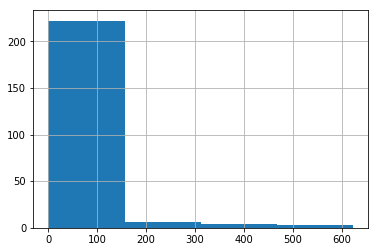

In [31]:
cairo_venues['Like Count'].hist(bins=4)
plt.show()

In [32]:
# Helper function to indicate rating
def rating(df):
    if df['Like Count'] <= 6.0:
        return 'Poor'
    elif df['Like Count'] <= 13.0:
        return 'Average'
    elif df['Like Count'] <= 34.0:
        return 'Good'
    elif df['Like Count'] > 34.0:
        return 'Excellent'
    else:
        raise ValueError("Wut")

In [33]:
cairo_venues['Rating'] = cairo_venues.apply(rating, axis=1)

In [34]:
cairo_venues

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating
0,Ain Shams,30.130476,31.316749,El Wally Cafe,50d766bae4b023bf8cc4191c,Café,30.130768,31.317696,2,Poor
3,Ain Shams,30.130476,31.316749,Mo'men (مؤمن),4f98614fe4b0fc88e6fea24d,Fast Food Restaurant,30.127758,31.320648,1,Poor
6,Azbakeya,30.053889,31.245473,Latif Wassily (لطيف وسيلي),4f7e9104e4b0e160b786d8dd,Bakery,30.054508,31.248270,28,Good
12,Azbakeya,30.053889,31.245473,Al Americaine (الأمريكين),4eb2c4a7cc21adeaf89acb9a,Café,30.052561,31.244304,35,Excellent
19,Azbakeya,30.053889,31.245473,Shalaby Hawawshi (حواوشي شلبي),506486d8e4b0593606e72415,Egyptian Restaurant,30.053207,31.242935,24,Good
20,Azbakeya,30.053889,31.245473,McDonald's,4db0b701fa8ca4b3e9e83b90,Fast Food Restaurant,30.051956,31.241425,27,Good
22,Azbakeya,30.053889,31.245473,Koshary Sayed Hanafy (كشرى سيد حنفى),53400cf9498e9792e60acab6,Egyptian Restaurant,30.053527,31.242905,5,Poor
23,Azbakeya,30.053889,31.245473,El Tabei El Domyati (التابعى الدمياطى),4e856185cc2143d95495b059,Falafel Restaurant,30.056195,31.242615,9,Average
25,Azbakeya,30.053889,31.245473,Akher Sa'a (أخر ساعة),5047b0bfe4b0ea030c588261,Falafel Restaurant,30.053594,31.243780,16,Good
26,Azbakeya,30.053889,31.245473,La Poire Cafe,4fd9b0f2e4b06a851a06d49a,Dessert Shop,30.050434,31.242612,8,Average


In [35]:
# one hot encoding
cairo_onehot = pd.get_dummies(cairo_venues[['Venue Category', 'Rating']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cairo_onehot['District'] = cairo_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [cairo_onehot.columns[-1]] + list(cairo_onehot.columns[:-1])
cairo_onehot = cairo_onehot[fixed_columns]

cairo_onehot.head()

,District,American Restaurant,Asian Restaurant,Bakery,Burger Joint,Cafeteria,Café,Candy Store,Chinese Restaurant,Coffee Shop,Cuban Restaurant,Cupcake Shop,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,German Restaurant,Hookah Bar,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Peruvian Restaurant,Pie Shop,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shawarma Place,Snack Place,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Yemeni Restaurant,Average,Excellent,Good,Poor
0,Ain Shams,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Ain Shams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,Azbakeya,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12,Azbakeya,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19,Azbakeya,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [36]:
cairo_onehot.shape

(235, 58)

let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
cairo_grouped = cairo_onehot.groupby('District').mean().reset_index()
cairo_grouped

,District,American Restaurant,Asian Restaurant,Bakery,Burger Joint,Cafeteria,Café,Candy Store,Chinese Restaurant,Coffee Shop,Cuban Restaurant,Cupcake Shop,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,German Restaurant,Hookah Bar,Hot Dog Joint,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Peruvian Restaurant,Pie Shop,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shawarma Place,Snack Place,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Yemeni Restaurant,Average,Excellent,Good,Poor
0,6th of October,0.00,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.00,0.055556,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.111111,0.00,0.000000,0.000000,0.055556,0.000000,0.055556,0.0,0.000000,0.000000,0.00,0.000000,0.166667,0.00,0.000000,0.055556,0.0,0.00,0.000000,0.055556,0.00,0.000000,0.00,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.222222,0.111111,0.277778,0.388889
1,Agouza,0.00,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.00,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.200000,0.00,0.000000,0.000000,0.2,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.800000,0.000000
2,Ain Shams,0.00,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,Azbakeya,0.00,0.000000,0.076923,0.000000,0.000000,0.230769,0.000000,0.00,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.153846,0.153846,0.076923,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.076923,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.076923,0.384615,0.384615
4,Boulaq,0.00,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.571429,0.00,0.000000,0.0000,0.0000,0.0000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.714286
5,Coptic Cairo,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,1.000000,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6,Daher,0.00,0.000000,0.083333,0.000000,0.000000,0.500000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.00,0.000000,0.000000,0.000000,0.000000,0.083333,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0

In [38]:
cairo_grouped.shape

(28, 58)

Let's print each neighborhood along with the top 5 most common venues

In [39]:
num_top_venues = 5

for district in cairo_grouped['District']:
    print("----"+district+"----")
    temp = cairo_grouped[cairo_grouped['District'] == district].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----6th of October----
              Venue  Frequency
0              Poor       0.39
1              Good       0.28
2           Average       0.22
3              Café       0.17
4  Kebab Restaurant       0.17


----Agouza----
                        Venue  Frequency
0                        Good        0.8
1  Modern European Restaurant        0.2
2                Burger Joint        0.2
3                   Excellent        0.2
4                        Café        0.2


----Ain Shams----
                  Venue  Frequency
0                  Poor        1.0
1                  Café        0.5
2  Fast Food Restaurant        0.5
3        Shawarma Place        0.0
4   Lebanese Restaurant        0.0


----Azbakeya----
                Venue  Frequency
0                Poor       0.38
1                Good       0.38
2                Café       0.23
3  Falafel Restaurant       0.15
4             Average       0.15


----Boulaq----
              Venue  Frequency
0              Poor       0.71
1 

#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 7 venues for each neighborhood.

In [41]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['District'] = cairo_grouped['District']

for ind in np.arange(cairo_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(cairo_grouped.iloc[ind, :], num_top_venues)

venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,6th of October,Poor,Good,Average,Café,Kebab Restaurant,Syrian Restaurant,Excellent
1,Agouza,Good,Modern European Restaurant,Excellent,Burger Joint,Kebab Restaurant,Café,Coffee Shop
2,Ain Shams,Poor,Café,Fast Food Restaurant,Donut Shop,Hot Dog Joint,Hookah Bar,German Restaurant
3,Azbakeya,Poor,Good,Café,Average,Falafel Restaurant,Egyptian Restaurant,Coffee Shop
4,Boulaq,Poor,Restaurant,Excellent,Average,Asian Restaurant,Café,Steakhouse
5,Coptic Cairo,Poor,Middle Eastern Restaurant,Donut Shop,Hot Dog Joint,Hookah Bar,German Restaurant,Fried Chicken Joint
6,Daher,Café,Good,Average,Poor,Fast Food Restaurant,Diner,Restaurant
7,Dokki,Average,Excellent,Good,Juice Bar,Café,Yemeni Restaurant,Middle Eastern Restaurant
8,Downtown Cairo,Poor,Bakery,Donut Shop,Hot Dog Joint,Hookah Bar,German Restaurant,Fried Chicken Joint
9,El-Manial,Poor,Average,Coffee Shop,Cafeteria,Ice Cream Shop,Fast Food Restaurant,Café


## 4. Clustering the districts
Run *k*-means to cluster the districts but first we have to determine the optimum number of clusters

In [42]:
labels = None
cairo_venues_all = cairo_onehot.drop('District', 1)

### Using Elbow Criterion Method

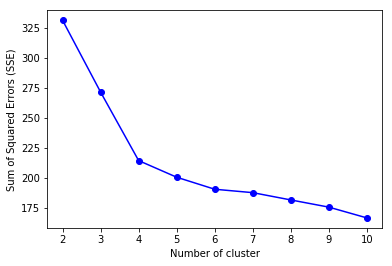

In [43]:
sse = {}
for n_cluster in range(2, 11):
    kmeans = KMeans(init="k-means++", n_clusters=n_cluster, random_state=0).fit(cairo_venues_all)
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[n_cluster] = kmeans.inertia_ 
sses = [float('inf'), float('inf')] + list(sse.values())    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='b')
plt.xlabel("Number of cluster")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()

### Using Silhouette Coefficient Method

In [44]:
coeffs = [0, 0]
for n_cluster in range(2, 11):
    kmeans = KMeans(init="k-means++", n_clusters=n_cluster, random_state=0).fit(cairo_venues_all)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(cairo_venues_all, labels, metric='euclidean')
    coeffs.append(sil_coeff)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.1686757701533035
For n_clusters=3, The Silhouette Coefficient is 0.24787600957585568
For n_clusters=4, The Silhouette Coefficient is 0.32647813241156176
For n_clusters=5, The Silhouette Coefficient is 0.2928826800706246
For n_clusters=6, The Silhouette Coefficient is 0.2785346234758919
For n_clusters=7, The Silhouette Coefficient is 0.29641621861618744
For n_clusters=8, The Silhouette Coefficient is 0.2612483495589942
For n_clusters=9, The Silhouette Coefficient is 0.28945745396533984
For n_clusters=10, The Silhouette Coefficient is 0.31624532353747037


In [45]:
sses = np.array(sses)
coeffs = np.array(coeffs)
opt_elbow = sses.argmin()
opt_sil = coeffs.argmax()
n_clusters =  opt_sil if opt_sil < opt_elbow else opt_elbow
n_clusters

4

In [46]:
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=0).fit(cairo_venues_all)
labels = kmeans.labels_
labels

array([3, 3, 2, 1, 2, 2, 3, 0, 2, 0, 2, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 2,
       0, 1, 2, 0, 3, 2, 0, 2, 0, 3, 2, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1,
       2, 2, 0, 2, 1, 3, 0, 3, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3,
       3, 3, 3, 0, 0, 3, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 3, 3, 0, 3, 1, 0,
       2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 3, 2, 1, 1, 0, 2, 0, 3, 3, 3, 3, 3,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 3, 1, 2, 2, 2, 2, 0, 0, 3,
       3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 2, 2,
       1, 2, 2, 0, 0, 3, 3, 2, 0, 3, 2, 0, 3, 3, 3, 1, 2, 1, 1, 2, 1, 2, 1,
       3, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1,
       2, 1, 0, 2, 0, 0, 3, 1, 2, 0, 2, 2, 0, 1, 1, 2, 3, 0, 0, 2, 3, 0, 3,
       3, 3, 2, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [49]:
cairo_venues['Cluster'] = kmeans.labels_
cairo_venues

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating,Cluster
0,Ain Shams,30.130476,31.316749,El Wally Cafe,50d766bae4b023bf8cc4191c,Café,30.130768,31.317696,2,Poor,3
3,Ain Shams,30.130476,31.316749,Mo'men (مؤمن),4f98614fe4b0fc88e6fea24d,Fast Food Restaurant,30.127758,31.320648,1,Poor,3
6,Azbakeya,30.053889,31.245473,Latif Wassily (لطيف وسيلي),4f7e9104e4b0e160b786d8dd,Bakery,30.054508,31.248270,28,Good,2
12,Azbakeya,30.053889,31.245473,Al Americaine (الأمريكين),4eb2c4a7cc21adeaf89acb9a,Café,30.052561,31.244304,35,Excellent,1
19,Azbakeya,30.053889,31.245473,Shalaby Hawawshi (حواوشي شلبي),506486d8e4b0593606e72415,Egyptian Restaurant,30.053207,31.242935,24,Good,2
20,Azbakeya,30.053889,31.245473,McDonald's,4db0b701fa8ca4b3e9e83b90,Fast Food Restaurant,30.051956,31.241425,27,Good,2
22,Azbakeya,30.053889,31.245473,Koshary Sayed Hanafy (كشرى سيد حنفى),53400cf9498e9792e60acab6,Egyptian Restaurant,30.053527,31.242905,5,Poor,3
23,Azbakeya,30.053889,31.245473,El Tabei El Domyati (التابعى الدمياطى),4e856185cc2143d95495b059,Falafel Restaurant,30.056195,31.242615,9,Average,0
25,Azbakeya,30.053889,31.245473,Akher Sa'a (أخر ساعة),5047b0bfe4b0ea030c588261,Falafel Restaurant,30.053594,31.243780,16,Good,2
26,Azbakeya,30.053889,31.245473,La Poire Cafe,4fd9b0f2e4b06a851a06d49a,Dessert Shop,30.050434,31.242612,8,Average,0


Finally, let's visualize the resulting clusters

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i+x+(i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cairo_venues['District Latitude'], cairo_venues['District Longitude'], cairo_venues['District'], cairo_venues['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1
- Features
    - Average quality food
    - Mostly Cafes

In [63]:
cairo_venues.loc[cairo_venues['Cluster'] == 0]

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating,Cluster
23,Azbakeya,30.053889,31.245473,El Tabei El Domyati (التابعى الدمياطى),4e856185cc2143d95495b059,Falafel Restaurant,30.056195,31.242615,9,Average,0
26,Azbakeya,30.053889,31.245473,La Poire Cafe,4fd9b0f2e4b06a851a06d49a,Dessert Shop,30.050434,31.242612,8,Average,0
39,Boulaq,30.063093,31.228926,Solana Restaurant,50580550e4b0b66b9511901f,Restaurant,30.065486,31.227720,8,Average,0
53,Daher,30.046661,31.323637,Cappuccino Cafe,4e39c21ad164102b0375fa23,Café,30.047037,31.324467,10,Average,0
56,Daher,30.046661,31.323637,Crystal Bakery (مخبز كريستال),4f3e386ee4b0fbbbd74f33c1,Bakery,30.048606,31.327970,13,Average,0
59,Daher,30.046661,31.323637,Moka Coffee,55a857b8498ed9bf2ac04a74,Café,30.044007,31.325126,11,Average,0
61,Daher,30.046661,31.323637,El Sokarreya (السكرية),4fcbacabe4b0c4b6a6cb90b0,Café,30.045573,31.324349,11,Average,0
68,El-Manial,30.027673,31.229000,Abo Hammam (ابو همام),5190d61c498e61f72a5494f3,Juice Bar,30.024338,31.226007,8,Average,0
69,El-Manial,30.027673,31.229000,Koshary El Moemen (كشري المؤمن),533bfac8498e176b286ea744,Egyptian Restaurant,30.025824,31.226286,8,Average,0
70,El-Manial,30.027673,31.229000,Saydala cafe (صيدلة كافيه),52030780498effdba9b2e3c1,Café,30.027999,31.232707,7,Average,0


#### Cluster 2
- Features
    - Excellent quality food
    - Mostly middle eastern oriented restaurants

In [59]:
cairo_venues.loc[cairo_venues['Cluster'] == 1]

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating,Cluster
12,Azbakeya,30.053889,31.245473,Al Americaine (الأمريكين),4eb2c4a7cc21adeaf89acb9a,Café,30.052561,31.244304,35,Excellent,1
42,Boulaq,30.063093,31.228926,Spectra,500857c6e4b0dbe2624e5406,Restaurant,30.065654,31.226778,156,Excellent,1
54,Daher,30.046661,31.323637,Nile Thailand Restaurant,4d23318e0901721e0726a9a5,Thai Restaurant,30.046354,31.327713,41,Excellent,1
79,Nasr City,30.052118,31.342205,Al-Awda (العودة),4ee397d70e011d524554e8a4,Falafel Restaurant,30.053379,31.342359,58,Excellent,1
84,Nasr City,30.052118,31.342205,Awlad TaTa (اولاد طأطأ),5075b693e4b0468f51822d71,Seafood Restaurant,30.054388,31.343465,39,Excellent,1
147,Islamic Cairo,30.048747,31.263775,Naguib Mahfouz Cafe (مقهى نجيب محفوظ),4ee2696393ad88a6bed30288,Café,30.047963,31.261567,409,Excellent,1
148,Islamic Cairo,30.048747,31.263775,El Fishawy (قهوة الفيشاوى),4b7bc840f964a520fe6d2fe3,Coffee Shop,30.047373,31.262556,421,Excellent,1
157,Islamic Cairo,30.048747,31.263775,Farahat (فرحات),4ed7e33a0e0189600bb9f6a0,Egyptian Restaurant,30.046465,31.261270,48,Excellent,1
159,Islamic Cairo,30.048747,31.263775,Zainab Khatoon (زينب خاتون),4e481a83483b03d090f653a8,Café,30.044588,31.263396,497,Excellent,1
183,Garden City,30.036417,31.231725,Zitouni,4cea21e20f196dcb8b1150ae,Lebanese Restaurant,30.036200,31.229422,35,Excellent,1


#### Cluster 3
- Features
    - Good quality food
    - Has food trucks

In [60]:
cairo_venues.loc[cairo_venues['Cluster'] == 2]

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating,Cluster
6,Azbakeya,30.053889,31.245473,Latif Wassily (لطيف وسيلي),4f7e9104e4b0e160b786d8dd,Bakery,30.054508,31.248270,28,Good,2
19,Azbakeya,30.053889,31.245473,Shalaby Hawawshi (حواوشي شلبي),506486d8e4b0593606e72415,Egyptian Restaurant,30.053207,31.242935,24,Good,2
20,Azbakeya,30.053889,31.245473,McDonald's,4db0b701fa8ca4b3e9e83b90,Fast Food Restaurant,30.051956,31.241425,27,Good,2
25,Azbakeya,30.053889,31.245473,Akher Sa'a (أخر ساعة),5047b0bfe4b0ea030c588261,Falafel Restaurant,30.053594,31.243780,16,Good,2
28,Azbakeya,30.053889,31.245473,Al Americaine (الأمريكين),4db1e0725da32cf2df66c763,Café,30.052414,31.241670,22,Good,2
52,Daher,30.046661,31.323637,El Faraana Cafe (قهوة الفراعنة),5159e314e4b086af7826a7d0,Café,30.047045,31.323439,15,Good,2
55,Daher,30.046661,31.323637,Hardee's,4cdeed4470bba1cd508063c4,Fast Food Restaurant,30.047803,31.328264,20,Good,2
58,Daher,30.046661,31.323637,Hawaii,4fa1a977e4b08da3595d0fc5,Hookah Bar,30.048023,31.322391,14,Good,2
60,Daher,30.046661,31.323637,Si Omar (سي عمر),4e2f2d4ffa7614797de0c627,Café,30.044256,31.325532,34,Good,2
64,Daher,30.046661,31.323637,Shagarteen Cafe,4d2ba87c77a2a1cddff87eb7,Café,30.043662,31.326005,14,Good,2


#### Cluster 4
- Features
    - Poor quality food
    - Mostly Cafes

In [61]:
cairo_venues.loc[cairo_venues['Cluster'] == 3]

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating,Cluster
0,Ain Shams,30.130476,31.316749,El Wally Cafe,50d766bae4b023bf8cc4191c,Café,30.130768,31.317696,2,Poor,3
3,Ain Shams,30.130476,31.316749,Mo'men (مؤمن),4f98614fe4b0fc88e6fea24d,Fast Food Restaurant,30.127758,31.320648,1,Poor,3
22,Azbakeya,30.053889,31.245473,Koshary Sayed Hanafy (كشرى سيد حنفى),53400cf9498e9792e60acab6,Egyptian Restaurant,30.053527,31.242905,5,Poor,3
29,Azbakeya,30.053889,31.245473,La Chesa,4bec4468976ac928e6c2600b,Swiss Restaurant,30.051197,31.242703,4,Poor,3
30,Azbakeya,30.053889,31.245473,Alfi Bek (الفي بيك),4e7cc021dab4ed68da56ab60,Middle Eastern Restaurant,30.053536,31.243486,4,Poor,3
31,Azbakeya,30.053889,31.245473,Om Kalthom Cafe,56b2830a498ee7829498f442,Café,30.055456,31.242710,4,Poor,3
32,Azbakeya,30.053889,31.245473,Layalina (ليالينا),4f7e4bf9e4b00dcb6975b023,Coffee Shop,30.053238,31.242396,5,Poor,3
41,Boulaq,30.063093,31.228926,Kamala Asian Bar & Dining,4ec54b8c0aaf9233edc5f9f2,Asian Restaurant,30.065569,31.227818,5,Poor,3
44,Boulaq,30.063093,31.228926,Pinci Coffe,505cc8e1e4b0707f48b41cb7,Café,30.065985,31.226835,5,Poor,3
46,Boulaq,30.063093,31.228926,The Lounge Restaurant,50ca02c1245f2d4aa8c2b6ad,Restaurant,30.062000,31.227800,0,Poor,3


#### Cluster 5

In [62]:
cairo_venues.loc[cairo_venues['Cluster'] == 4]

,District,District Latitude,District Longitude,Venue,Venue ID,Venue Category,Venue Latitude,Venue Longitude,Like Count,Rating,Cluster


# Done!